## Which European Capital for a GetAway? 

### Capstone Project - Data Science

#### Andrea Dal Bianco - 15/03/2021

Importing the needed libraries

In [1]:
import pandas as pd

import requests 
import numpy as np 
import random 

from geopy.geocoders import Nominatim 

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium 

Create a list with the capital of interest. We will use this list to select only the data regarding these capitals.

In [2]:
List=["London","Paris","Amsterdam","Brussels","Copenhagen","Stockholm","Oslo","Rome","Madrid","Lisbon","Berlin","Prague","Vienna","Budapest"]

Import geo data and population information from csv file and wikipedia table. We will briefly clean the data and remove unwanted columns.

In [3]:
caps = pd.read_csv("/Users/PQK9474/OneDrive - Takeda/COUR/Python Capstone/country-capitals.csv")

caps_eu = caps.loc[caps["ContinentName"]=="Europe"]

link1 = "https://worldpopulationreview.com/continents/cities/europe"
table1 = pd.read_html(link1)

pop = table1[0].iloc[:]


pop_eu=pop.loc[pop["Name"].isin(List)]

data_eu = pd.merge(pop_eu,caps_eu,how="left",left_on="Name",right_on="CapitalName")

data_eu = data_eu[["Name","2021 Population","CapitalLatitude","CapitalLongitude"]]

We add the column "Area" which assigns one geographical area given by our customer to each city.

In [4]:
data_eu["Area"]=""

data_eu["Area"].iloc[0]="Center_west"
data_eu["Area"].iloc[1]="Center_east"
data_eu["Area"].iloc[2]="South"
data_eu["Area"].iloc[3]="South"
data_eu["Area"].iloc[4]="Center_west"
data_eu["Area"].iloc[5]="Center_east"
data_eu["Area"].iloc[6]="Center_east"
data_eu["Area"].iloc[7]="North"
data_eu["Area"].iloc[8]="Center_east"
data_eu["Area"].iloc[9]="North"
data_eu["Area"].iloc[10]="Center_west"
data_eu["Area"].iloc[11]="Center_west"
data_eu["Area"].iloc[12]="North"
data_eu["Area"].iloc[13]="South"

area=data_eu[["Name","Area"]]

C:\Users\PQK9474\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
data_eu

,Name,2021 Population,CapitalLatitude,CapitalLongitude,Area
0,London,7556900,51.500000,-0.083333,Center_west
1,Berlin,3426354,52.516667,13.400000,Center_east
2,Madrid,3255944,40.400000,-3.683333,South
3,Rome,2318895,41.900000,12.483333,South
4,Paris,2138551,48.866667,2.333333,Center_west
5,Budapest,1741041,47.500000,19.083333,Center_east
6,Vienna,1691468,48.200000,16.366667,Center_east
7,Stockholm,1515017,59.333333,18.050000,North
8,Prague,1165581,50.083333,14.466667,Center_east
9,Copenhagen,1153615,55.666667,12.583333,North


Now that we have the coordinates of each city, we perform a search using the FourSquare API. We will search for all venues within a 5 Km radius. The search limit of our account is set to 100, so we will retrieve only 100 venues per city.

In [6]:
CLIENT_ID = "J5ABSPDWZTBPOMBJJU51PUJFW35K4O2JSQ201I14KDAHQLC3"
CLIENT_SECRET = "GSP5UXVSPCOS3GHL1XZ1BXHYNW2HJM35HHIKPNC551MF0VVY"
ACCESS_TOKEN = "NKCID3FOEPCVPERYOUS3IVFRQI2MC12CADQ3AS0WSOXP4LKW"
VERSION = '20210313'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

name = data_eu["Name"]
lat = data_eu["CapitalLatitude"].astype(float).round(6).astype(str)
lon = data_eu["CapitalLongitude"].astype(float).round(6).astype(str)

def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Your credentails:
CLIENT_ID: J5ABSPDWZTBPOMBJJU51PUJFW35K4O2JSQ201I14KDAHQLC3
CLIENT_SECRET:GSP5UXVSPCOS3GHL1XZ1BXHYNW2HJM35HHIKPNC551MF0VVY


In [7]:
eu_venues = getNearbyVenues(name,lat,lon,radius=5000)

London
Berlin
Madrid
Rome
Paris
Budapest
Vienna
Stockholm
Prague
Copenhagen
Brussels
Amsterdam
Oslo
Lisbon


We retrieve the data for the cost of living from a website. We perform some data cleaning and check if all the cities have now a corresponding cost of living value.

In [8]:
link3 = "https://myfunkytravel.com/cost-of-living-european-cities-ranking.html"
table3 = pd.read_html(link3)

cost = table3[0].iloc[:]

cost.to_csv("/Users/PQK9474/OneDrive - Takeda/COUR/Python Capstone/cost_eu.csv", index=False)

cost.columns = cost.iloc[0]
cost.drop(cost.index[0],inplace=True)

cost_eu= cost.loc[cost["CAPITAL CITY"].isin(List)]

cost_eu.reset_index(drop=True,inplace=True)
cost_eu.drop(["RENTING ACCOMODATION"],axis=1,inplace=True)

print("The cost of living data have been retrieved for ",cost_eu.shape[0]," cities")

The cost of living data have been retrieved for  13  cities


C:\Users\PQK9474\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


We see that we only have data for 13 cities. In our list we have 14 cities. We check which city is missing by quickly displaying the dataset.

In [9]:
cost_eu

,COUNTRY,CAPITAL CITY,ESTIMATED COST OF LIVING(EUROS/MONTH)
0,UK,London,1926
1,Denmark,Copenhagen,1719
2,Netherlands,Amsterdam,1702
3,France,Paris,1660
4,Sweden,Stockholm,1576
5,Italy,Rome,1387
6,Austria,Vienna,1341
7,Belgium,Brussels,1387
8,Germany,Berlin,1258
9,Spain,Madrid,1168


Oslo is missing. Instead of getting the data from another source that might not be comparable, we will assign to Oslo the same value as Sotckholm, since both cities have historically comparable cost of living. 

In [10]:
cost_oslo = pd.DataFrame({"COUNTRY":["Norway"],"CAPITAL CITY":["Oslo"],"ESTIMATED COST OF LIVING(EUROS/MONTH)":cost["ESTIMATED COST OF LIVING(EUROS/MONTH)"].loc[cost["COUNTRY"]=="Sweden"]})
cost_oslo

,COUNTRY,CAPITAL CITY,ESTIMATED COST OF LIVING(EUROS/MONTH)
7,Norway,Oslo,1576


We then append the row to the existing table and perform some data cleaning

In [11]:
cost_eu1 = cost_eu.append(cost_oslo)

cost_eu1.reset_index(drop=True,inplace=True)
cost_eu1
cost_eu2 = cost_eu1[["CAPITAL CITY","ESTIMATED COST OF LIVING(EUROS/MONTH)"]]

The venues retrieved through the FourSquare API are divided into 212 categories. However, to respect the specification of our client, we need to have 4 types: food, nightlife, freetime and shopping. We now proceed to divide the different categories into this 4 types.

In [12]:
venues_cat = eu_venues["Venue Category"].value_counts()

venues_cat[0:5]

eu_venues1 = eu_venues

eu_venues1["Venue Type"] = ""

Food_List=["Café","Bakery","Ice Cream Shop","Restaurant","Pizza Place","Italian Restaurant","Scandinavian Restaurant",
           "French Restaurant","Burger Joint","Tapas Restaurant","Sandwich Place","Bistro",
          "Vegetarian / Vegan Restaurant","Sushi Restaurant","Dessert Shop","Gourmet Shop",
          "Indian Restaurant","Austrian Restaurant","Vietnamese Restaurant","Breakfast Spot",
           "Mediterranean Restaurant","Asia Restaurant","Tea Room","Portuguese Restaurant","Spanish Restaurant",
          "Thai Restaurant","Seafood Restaurant","Pastry Shop","BBQ Joint","Food Court",
          "Korean Restaurant"]

Nightlife_List=["Coffee Shop","Hotel","Cocktail Bar","Wine Bar","Bar","Beer Bar","Hostel","Brewery","Music Venue",
               "Pub","Lounge"]

Freetime_List=["Plaza","Park","Art Museum","Garden","Scenic Lookout","Theater","Historic Site","Concert Hall",
              "Art Gallery","Indie Movie Theater","Monument / Landmark","Yoga Studio","Gym / Fitness Center",
              "Fountain","Movie Theater","Castle","Palace","History Museum","Opera House","Performing Arts Venue",
              "Playground","Exhibit"]

Shopping_List=["Farmers Market","Grocery Store","Chocolate Shop","Wine Shop","Beer Store","Cheese Shop",
               "Toy / Game Store","Market","Boutique","Clothing Store","Record Shop"]

x=0
for x in range (0,1399):
    n=x
    if eu_venues1["Venue Category"][n] in Food_List:
        eu_venues1["Venue Type"][n]="Food"
    x=x+1
    

x=0
for x in range (0,1399):
    n=x
    if eu_venues1["Venue Category"][n] in Nightlife_List:
        eu_venues1["Venue Type"][n]="Nightlife"
    x=x+1
    

x=0
for x in range (0,1399):
    n=x
    if eu_venues1["Venue Category"][n] in Freetime_List:
        eu_venues1["Venue Type"][n]="Freetime"
    x=x+1
    

x=0
for x in range (0,1399):
    n=x
    if eu_venues1["Venue Category"][n] in Shopping_List:
        eu_venues1["Venue Type"][n]="Shopping"
    x=x+1

#   
#keep columns if interest, remove rows without venue type
eu_venue_data = eu_venues1[["City","City Latitude","City Longitude","Venue Type"]]

eu_venue_data1 = eu_venue_data.loc[eu_venue_data["Venue Type"]!=""]

eu_venue_data1.reset_index(inplace=True,drop=True)

<ipython-input-12-2a2d326025d9>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_venues1["Venue Type"][n]="Food"
<ipython-input-12-2a2d326025d9>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_venues1["Venue Type"][n]="Nightlife"
<ipython-input-12-2a2d326025d9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_venues1["Venue Type"][n]="Freetime"
<ipython-input-12-2a2d326025d9>:56: SettingWithCopyWarning: 
A value is trying 

In order to use k-means, we use one-hot encoding to transform the categorical data into numerical data.

In [13]:
eu_onehot = pd.get_dummies(eu_venue_data1[['Venue Type']], prefix="", prefix_sep="")
eu_onehot['City'] = eu_venue_data1['City'] 

fixed_columns = [eu_onehot.columns[-1]] + list(eu_onehot.columns[:-1])
eu_onehot = eu_onehot[fixed_columns]

In [14]:
eu_onehot

,City,Food,Freetime,Nightlife,Shopping
0,London,1,0,0,0
1,London,0,1,0,0
2,London,1,0,0,0
3,London,0,0,1,0
4,London,0,0,0,1
...,...,...,...,...,...
1104,Lisbon,1,0,0,0
1105,Lisbon,0,0,0,1
1106,Lisbon,0,0,1,0
1107,Lisbon,1,0,0,0


Divide the dataframe into subsets for each city.

In [15]:
Amsterdam = eu_onehot.loc[eu_onehot["City"]=="Amsterdam"]
Berlin = eu_onehot.loc[eu_onehot["City"]=="Berlin"]
Brussels = eu_onehot.loc[eu_onehot["City"]=="Brussels"]
Budapest = eu_onehot.loc[eu_onehot["City"]=="Budapest"]
Copenhagen = eu_onehot.loc[eu_onehot["City"]=="Copenhagen"]
Lisbon = eu_onehot.loc[eu_onehot["City"]=="Lisbon"]
London = eu_onehot.loc[eu_onehot["City"]=="London"]
Madrid = eu_onehot.loc[eu_onehot["City"]=="Madrid"]
Oslo = eu_onehot.loc[eu_onehot["City"]=="Oslo"]
Paris = eu_onehot.loc[eu_onehot["City"]=="Paris"]
Prague = eu_onehot.loc[eu_onehot["City"]=="Prague"]
Rome = eu_onehot.loc[eu_onehot["City"]=="Rome"]
Stockholm = eu_onehot.loc[eu_onehot["City"]=="Stockholm"]
Vienna = eu_onehot.loc[eu_onehot["City"]=="Vienna"]

To each data subset we add the sum of the number of venues per category. Each dataframe (city) now has one column for food, nightlife, freetime and shopping with the number of venues found for that type. A total column has also been added.

In [16]:
Amsterdam1 = pd.DataFrame({"City":["Amsterdam"], "Food":[Amsterdam["Food"].sum()],"Nightlife":[Amsterdam["Nightlife"].sum()],
                       "Freetime":[Amsterdam["Freetime"].sum()],"Shopping":[Amsterdam["Shopping"].sum()],
                       "Total Venues":[Amsterdam["Food"].sum()+Amsterdam["Nightlife"].sum()+Amsterdam["Freetime"].sum()+
                        Amsterdam["Shopping"].sum()]})

In [17]:
Berlin1 = pd.DataFrame({"City":["Berlin"], "Food":[Berlin["Food"].sum()],"Nightlife":[Berlin["Nightlife"].sum()],
                       "Freetime":[Berlin["Freetime"].sum()],"Shopping":[Berlin["Shopping"].sum()],
                       "Total Venues":[Berlin["Food"].sum()+Berlin["Nightlife"].sum()+Berlin["Freetime"].sum()+
                        Berlin["Shopping"].sum()]})

In [18]:
Brussels1 = pd.DataFrame({"City":["Brussels"], "Food":[Brussels["Food"].sum()],"Nightlife":[Brussels["Nightlife"].sum()],
                       "Freetime":[Brussels["Freetime"].sum()],"Shopping":[Brussels["Shopping"].sum()],
                       "Total Venues":[Brussels["Food"].sum()+Brussels["Nightlife"].sum()+Brussels["Freetime"].sum()+
                        Brussels["Shopping"].sum()]})

In [19]:
Budapest1 = pd.DataFrame({"City":["Budapest"], "Food":[Budapest["Food"].sum()],"Nightlife":[Budapest["Nightlife"].sum()],
                       "Freetime":[Budapest["Freetime"].sum()],"Shopping":[Budapest["Shopping"].sum()],
                       "Total Venues":[Budapest["Food"].sum()+Budapest["Nightlife"].sum()+Budapest["Freetime"].sum()+
                        Budapest["Shopping"].sum()]})

In [20]:
Copenhagen1 = pd.DataFrame({"City":["Copenhagen"], "Food":[Copenhagen["Food"].sum()],"Nightlife":[Copenhagen["Nightlife"].sum()],
                       "Freetime":[Copenhagen["Freetime"].sum()],"Shopping":[Copenhagen["Shopping"].sum()],
                       "Total Venues":[Copenhagen["Food"].sum()+Copenhagen["Nightlife"].sum()+Copenhagen["Freetime"].sum()+
                        Copenhagen["Shopping"].sum()]})

In [21]:
Lisbon1 = pd.DataFrame({"City":["Lisbon"], "Food":[Lisbon["Food"].sum()],"Nightlife":[Lisbon["Nightlife"].sum()],
                       "Freetime":[Lisbon["Freetime"].sum()],"Shopping":[Lisbon["Shopping"].sum()],
                       "Total Venues":[Lisbon["Food"].sum()+Lisbon["Nightlife"].sum()+Lisbon["Freetime"].sum()+
                        Lisbon["Shopping"].sum()]})

In [22]:
London1 = pd.DataFrame({"City":["London"], "Food":[London["Food"].sum()],"Nightlife":[London["Nightlife"].sum()],
                       "Freetime":[London["Freetime"].sum()],"Shopping":[London["Shopping"].sum()],
                       "Total Venues":[London["Food"].sum()+London["Nightlife"].sum()+London["Freetime"].sum()+
                        London["Shopping"].sum()]})

In [23]:
Madrid1 = pd.DataFrame({"City":["Madrid"], "Food":[Madrid["Food"].sum()],"Nightlife":[Madrid["Nightlife"].sum()],
                       "Freetime":[Madrid["Freetime"].sum()],"Shopping":[Madrid["Shopping"].sum()],
                       "Total Venues":[Madrid["Food"].sum()+Madrid["Nightlife"].sum()+Madrid["Freetime"].sum()+
                        Madrid["Shopping"].sum()]})

In [24]:
Oslo1 = pd.DataFrame({"City":["Oslo"], "Food":[Oslo["Food"].sum()],"Nightlife":[Oslo["Nightlife"].sum()],
                       "Freetime":[Oslo["Freetime"].sum()],"Shopping":[Oslo["Shopping"].sum()],
                       "Total Venues":[Oslo["Food"].sum()+Oslo["Nightlife"].sum()+Oslo["Freetime"].sum()+
                        Oslo["Shopping"].sum()]})

In [25]:
Paris1 = pd.DataFrame({"City":["Paris"], "Food":[Paris["Food"].sum()],"Nightlife":[Paris["Nightlife"].sum()],
                       "Freetime":[Paris["Freetime"].sum()],"Shopping":[Paris["Shopping"].sum()],
                       "Total Venues":[Paris["Food"].sum()+Paris["Nightlife"].sum()+Paris["Freetime"].sum()+
                        Paris["Shopping"].sum()]})

In [26]:
Prague1 = pd.DataFrame({"City":["Prague"], "Food":[Prague["Food"].sum()],"Nightlife":[Prague["Nightlife"].sum()],
                       "Freetime":[Prague["Freetime"].sum()],"Shopping":[Prague["Shopping"].sum()],
                       "Total Venues":[Prague["Food"].sum()+Prague["Nightlife"].sum()+Prague["Freetime"].sum()+
                        Prague["Shopping"].sum()]})

In [27]:
Rome1 = pd.DataFrame({"City":["Rome"], "Food":[Rome["Food"].sum()],"Nightlife":[Rome["Nightlife"].sum()],
                       "Freetime":[Rome["Freetime"].sum()],"Shopping":[Rome["Shopping"].sum()],
                       "Total Venues":[Rome["Food"].sum()+Rome["Nightlife"].sum()+Rome["Freetime"].sum()+
                        Rome["Shopping"].sum()]})

In [28]:
Stockholm1 = pd.DataFrame({"City":["Stockholm"], "Food":[Stockholm["Food"].sum()],"Nightlife":[Stockholm["Nightlife"].sum()],
                       "Freetime":[Stockholm["Freetime"].sum()],"Shopping":[Stockholm["Shopping"].sum()],
                       "Total Venues":[Stockholm["Food"].sum()+Stockholm["Nightlife"].sum()+Stockholm["Freetime"].sum()+
                        Stockholm["Shopping"].sum()]})

In [29]:
Vienna1 = pd.DataFrame({"City":["Vienna"], "Food":[Vienna["Food"].sum()],"Nightlife":[Vienna["Nightlife"].sum()],
                       "Freetime":[Vienna["Freetime"].sum()],"Shopping":[Vienna["Shopping"].sum()],
                       "Total Venues":[Vienna["Food"].sum()+Vienna["Nightlife"].sum()+Vienna["Freetime"].sum()+
                        Vienna["Shopping"].sum()]})

Create empty Dataframe and then append the dataframes for each city.

In [30]:
eu_onehot_data= pd.DataFrame({})

In [31]:
eu_onehot_data = eu_onehot_data.append([Amsterdam1,Berlin1,Brussels1,Budapest1,Copenhagen1,Lisbon1,London1,Madrid1,Oslo1,
                      Paris1,Prague1,Rome1,Stockholm1,Vienna1])
eu_onehot_data.reset_index(drop=True,inplace=True)

Merge the geographical data.

In [32]:

eu_venue_data2 = eu_venue_data1[["City","City Latitude","City Longitude"]]
eu_venue_data2.drop_duplicates(inplace=True)

eu_fine = pd.merge(eu_onehot_data,eu_venue_data2,how="left",on="City")

<ipython-input-32-38d7dcf69ab7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_venue_data2.drop_duplicates(inplace=True)


Merge the population data.

In [41]:
# keep useful data about population and merge
data_eu1 = data_eu[["Name","2021 Population"]]

eu_fine1 = pd.merge(eu_fine,data_eu1,how="left",left_on="City",right_on="Name")
eu_fine1.drop(["Name"],axis=1,inplace=True)
eu_fine1["City Latitude"]=eu_fine1["City Latitude"].astype(float)
eu_fine1["City Longitude"]=eu_fine1["City Longitude"].astype(float)

Merge cost of living data.

In [42]:
eu_fine2 = pd.merge(eu_fine1,cost_eu2,how="left",left_on="City",right_on="CAPITAL CITY")
eu_fine2.drop(["CAPITAL CITY"],axis=1,inplace=True)

Quick overview by city.

In [43]:
eu_fine2

,City,Food,Nightlife,Freetime,Shopping,Total Venues,City Latitude,City Longitude,2021 Population,ESTIMATED COST OF LIVING(EUROS/MONTH)
0,Amsterdam,25,28,17,4,74,52.350000,4.916667,741636,1702
1,Berlin,26,16,28,3,73,52.516667,13.400000,3426354,1258
2,Brussels,20,22,21,17,80,50.833333,4.333333,1019022,1387
3,Budapest,34,28,14,3,79,47.500000,19.083333,1741041,809
4,Copenhagen,26,22,25,5,78,55.666667,12.583333,1153615,1719
5,Lisbon,32,26,23,1,82,38.716667,-9.133333,517802,1004
6,London,19,31,29,6,85,51.500000,-0.083333,7556900,1926
7,Madrid,33,12,35,4,84,40.400000,-3.683333,3255944,1168
8,Oslo,34,27,14,6,81,59.916667,10.750000,580000,1576
9,Paris,19,15,38,3,75,48.866667,2.333333,2138551,1660


We will now create city clusters based on the number of different venues. We investigate if we should consider the absolute number of venues or the relative number of venues (i.e. number of venues per 100.000 inhabitants, in order to account for the difference in population).

Dividing by Population to obtain venues per 100.000 inhabitants. 

In [44]:
eu_prop = eu_fine1

eu_prop["Div"]= eu_prop["2021 Population"]/100000

eu_prop["Total_p"] = eu_prop["Total Venues"]/eu_prop["Div"]

eu_prop1 = eu_prop[["City","2021 Population","Total_p"]]

eu_corr = eu_prop1.sort_values(by=["2021 Population"])
eu_corr

,City,2021 Population,Total_p
5,Lisbon,517802,15.836169
8,Oslo,580000,13.965517
0,Amsterdam,741636,9.977941
2,Brussels,1019022,7.850665
4,Copenhagen,1153615,6.761355
10,Prague,1165581,7.120912
12,Stockholm,1515017,5.082451
13,Vienna,1691468,4.493139
3,Budapest,1741041,4.537515
9,Paris,2138551,3.507048


We notice that there is a very strong dependence between the population and the total number of venues per 100.000 inhabitants. Specifically, cities with high population have very low number of venues per 100.000 inhabitnats. This is caused by the search limit which only finds 100 location per city. Therefore, the relative number of venues is not a good metric for our analysis. We will cluster using the absolute number of venues.

Print the value of the mean coordinate to center the map

In [45]:
print("Mean Latitude is: ",eu_fine1["City Latitude"].mean(),"\nMean Longitude is: ",eu_fine1["City Longitude"].mean())

Mean Latitude is:  49.84166671428572 
Mean Longitude is:  8.2761905


Clustering data for total venues and displaying results on a map

In [46]:
kclusters = 4

eu_clustering = eu_fine1[["Total Venues"]]

kmeans_all = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_clustering)


eu_overall = eu_fine1[["City","Total Venues","City Latitude","City Longitude"]]
eu_overall.insert(0, 'Cluster Labels', kmeans_all.labels_)

In [47]:

map_overall = folium.Map(location=[49.84,8.27], zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_overall['City Latitude'], eu_overall['City Longitude'], eu_overall['City'], eu_overall['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_overall)
       
map_overall

Clustering data for food venues and displaying result on a map.

In [48]:
kclusters = 4

eu_clustering_food = eu_fine1[["Food"]]

kmeans_food = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_clustering_food)

eu_food = eu_fine1[["City","Food","City Latitude","City Longitude"]]
eu_food.insert(0, 'Cluster Labels', kmeans_food.labels_)

In [49]:

map_food = folium.Map(location=[49.84,8.27], zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_food['City Latitude'], eu_food['City Longitude'], eu_food['City'], eu_food['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_food)
       
map_food

Clustering data for nightlife venues and displaying result on a map.

In [50]:
kclusters = 4

eu_nightlife = eu_fine1[["Nightlife"]]

kmeans_nightlife = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_nightlife)

eu_nightlife = eu_fine1[["City","Nightlife","City Latitude","City Longitude"]]
eu_nightlife.insert(0, 'Cluster Labels', kmeans_nightlife.labels_)

In [51]:

map_nightlife = folium.Map(location=[49.84,8.27], zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_nightlife['City Latitude'], eu_nightlife['City Longitude'], eu_nightlife['City'], eu_nightlife['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_nightlife)
       
map_nightlife

Clustering data for freetime venues and displaying result on a map.

In [52]:

kclusters = 4

eu_freetime = eu_fine1[["Freetime"]]


kmeans_freetime = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_freetime)

eu_freetime = eu_fine1[["City","Freetime","City Latitude","City Longitude"]]
eu_freetime.insert(0, 'Cluster Labels', kmeans_freetime.labels_)

In [53]:

map_freetime = folium.Map(location=[49.84,8.27], zoom_start=4)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_freetime['City Latitude'], eu_freetime['City Longitude'], eu_freetime['City'], eu_freetime['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_freetime)
       
map_freetime

Clustering data for shopping venues and displaying result on a map.

In [54]:

kclusters = 4

eu_shopping = eu_fine1[["Shopping"]]


kmeans_shopping = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_shopping)

eu_shopping = eu_fine1[["City","Shopping","City Latitude","City Longitude"]]
eu_shopping.insert(0, 'Cluster Labels', kmeans_shopping.labels_)

In [55]:

map_shopping = folium.Map(location=[49.84,8.27], zoom_start=4)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_shopping['City Latitude'], eu_shopping['City Longitude'], eu_shopping['City'], eu_shopping['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_shopping)
       
map_shopping

Clustering data for cost of living and displaying result on a map.

In [56]:
kclusters = 3

eu_costlife = eu_fine2[["ESTIMATED COST OF LIVING(EUROS/MONTH)"]].astype(float)

kmeans_costlife = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_costlife)

eu_costlife = eu_fine2[["City","ESTIMATED COST OF LIVING(EUROS/MONTH)","City Latitude","City Longitude"]]
eu_costlife.insert(0, 'Cluster Labels', kmeans_costlife.labels_)
eu_costlife["ESTIMATED COST OF LIVING(EUROS/MONTH)"]=eu_costlife["ESTIMATED COST OF LIVING(EUROS/MONTH)"].astype(float)

<ipython-input-56-aa3bff8aae45>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_costlife["ESTIMATED COST OF LIVING(EUROS/MONTH)"]=eu_costlife["ESTIMATED COST OF LIVING(EUROS/MONTH)"].astype(float)


In [57]:

map_costlife = folium.Map(location=[49.84,8.27], zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_costlife['City Latitude'], eu_costlife['City Longitude'], eu_costlife['City'], eu_costlife['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_costlife)
       
map_costlife

Clustering data for population and displaying result on a map.

In [58]:
kclusters = 3

eu_pop = eu_fine2[["2021 Population"]].astype(float)

kmeans_pop = KMeans(n_clusters=kclusters, random_state=0,n_init=11).fit(eu_pop)

eu_pop = eu_fine2[["City","2021 Population","City Latitude","City Longitude"]]
eu_pop.insert(0, 'Cluster Labels', kmeans_pop.labels_)


In [59]:
map_pop = folium.Map(location=[49.84,8.27], zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(eu_pop['City Latitude'], eu_pop['City Longitude'], eu_pop['City'], eu_pop['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_pop)
       
map_pop

Assigning score to the clusters.

In [73]:
eu_food1 = eu_food

eu_food1["Cluster"]=eu_food1["Cluster Labels"]
eu_food2 = eu_food1.sort_values(by=["Food"])


food_0= eu_food2.loc[eu_food2["Cluster"]==0]
food_1= eu_food2.loc[eu_food2["Cluster"]==1]
food_2= eu_food2.loc[eu_food2["Cluster"]==2]
food_3= eu_food2.loc[eu_food2["Cluster"]==3]

food_0["food_score"]=np.where(food_0.Cluster == 0,50,0)
food_1["food_score"]=np.where(food_1.Cluster == 1,100,0)
food_2["food_score"]=np.where(food_2.Cluster == 2,25,0)
food_3["food_score"]=np.where(food_3.Cluster == 3,75,0)

food_score = pd.concat([food_0,food_1,food_2,food_3])

food_score1 = food_score[["City","food_score"]]



eu_nightlife1 = eu_nightlife

eu_nightlife1["Cluster"]=eu_nightlife1["Cluster Labels"]
eu_nightlife2 = eu_nightlife1.sort_values(by=["Nightlife"])

nightlife_0= eu_nightlife2.loc[eu_nightlife2["Cluster"]==0]
nightlife_1= eu_nightlife2.loc[eu_nightlife2["Cluster"]==1]
nightlife_2= eu_nightlife2.loc[eu_nightlife2["Cluster"]==2]
nightlife_3= eu_nightlife2.loc[eu_nightlife2["Cluster"]==3]

nightlife_0["nightlife_score"]=np.where(nightlife_0.Cluster == 0,25,0)
nightlife_1["nightlife_score"]=np.where(nightlife_1.Cluster == 1,100,0)
nightlife_2["nightlife_score"]=np.where(nightlife_2.Cluster == 2,50,0)
nightlife_3["nightlife_score"]=np.where(nightlife_3.Cluster == 3,75,0)

nightlife_score = pd.concat([nightlife_0,nightlife_1,nightlife_2,nightlife_3])

nightlife_score1 = nightlife_score[["City","nightlife_score"]]



eu_freetime1 = eu_freetime

eu_freetime1["Cluster"]=eu_freetime1["Cluster Labels"]
eu_freetime2 = eu_freetime1.sort_values(by=["Freetime"])

freetime_0= eu_freetime2.loc[eu_freetime2["Cluster"]==0]
freetime_1= eu_freetime2.loc[eu_freetime2["Cluster"]==1]
freetime_2= eu_freetime2.loc[eu_freetime2["Cluster"]==2]
freetime_3= eu_freetime2.loc[eu_freetime2["Cluster"]==3]

freetime_0["freetime_score"]=np.where(freetime_0.Cluster == 0,25,0)
freetime_1["freetime_score"]=np.where(freetime_1.Cluster == 1,75,0)
freetime_2["freetime_score"]=np.where(freetime_2.Cluster == 2,100,0)
freetime_3["freetime_score"]=np.where(freetime_3.Cluster == 3,50,0)

freetime_score = pd.concat([freetime_0,freetime_1,freetime_2,freetime_3])

freetime_score1 = freetime_score[["City","freetime_score"]]



eu_shopping1 = eu_shopping

eu_shopping1["Cluster"]=eu_shopping1["Cluster Labels"]
eu_shopping2 = eu_shopping1.sort_values(by=["Shopping"])

shopping_0= eu_shopping2.loc[eu_shopping2["Cluster"]==0]
shopping_1= eu_shopping2.loc[eu_shopping2["Cluster"]==1]
shopping_2= eu_shopping2.loc[eu_shopping2["Cluster"]==2]
shopping_3= eu_shopping2.loc[eu_shopping2["Cluster"]==3]

shopping_0["shopping_score"]=np.where(shopping_0.Cluster == 0,75,0)
shopping_1["shopping_score"]=np.where(shopping_1.Cluster == 1,100,0)
shopping_2["shopping_score"]=np.where(shopping_2.Cluster == 2,50,0)
shopping_3["shopping_score"]=np.where(shopping_3.Cluster == 3,25,0)

shopping_score = pd.concat([shopping_0,shopping_1,shopping_2,shopping_3])

shopping_score1 = shopping_score[["City","shopping_score"]]



eu_pop1 = eu_pop

eu_pop1["Cluster"]=eu_pop1["Cluster Labels"]
eu_pop2 = eu_pop1.sort_values(by=["2021 Population"])

pop_0= eu_pop2.loc[eu_pop2["Cluster"]==0]
pop_1= eu_pop2.loc[eu_pop2["Cluster"]==1]
pop_2= eu_pop2.loc[eu_pop2["Cluster"]==2]


pop_0["Population"]=np.where(pop_0.Cluster == 0,"Medium",0)
pop_1["Population"]=np.where(pop_1.Cluster == 1,"High",0)
pop_2["Population"]=np.where(pop_2.Cluster == 2,"Low",0)


pop_score = pd.concat([pop_0,pop_1,pop_2])

pop_score1 = pop_score[["City","Population"]]



eu_costlife1 = eu_costlife

eu_costlife1["Cluster"]=eu_costlife1["Cluster Labels"]
eu_costlife2 = eu_costlife1.sort_values(by=["ESTIMATED COST OF LIVING(EUROS/MONTH)"])

costlife_0= eu_costlife2.loc[eu_costlife2["Cluster"]==0]
costlife_1= eu_costlife2.loc[eu_costlife2["Cluster"]==1]
costlife_2= eu_costlife2.loc[eu_costlife2["Cluster"]==2]


costlife_0["Cost"]=np.where(costlife_0.Cluster == 0,"High",0)
costlife_1["Cost"]=np.where(costlife_1.Cluster == 1,"Low",0)
costlife_2["Cost"]=np.where(costlife_2.Cluster == 2,"Medium",0)


costlife_score = pd.concat([costlife_0,costlife_1,costlife_2])

costlife_score1 = costlife_score[["City","Cost"]]



scores = pd.merge(area,food_score1,how="left",left_on="Name",right_on="City")
scores = scores[["City","Area","food_score"]]
scores1 = pd.merge(scores,nightlife_score1,how="left",on="City")
scores2 = pd.merge(scores1,freetime_score1,how="left",on="City")
scores3 = pd.merge(scores2,shopping_score1,how="left",on="City")
scores4 = pd.merge(scores3,pop_score1,how="left",on="City")
scores5 = pd.merge(scores4,costlife_score1,how="left",on="City")

scores5["Sum"]=scores5["food_score"]+scores5["nightlife_score"]+scores5["freetime_score"]+scores5["shopping_score"]

scores_final = scores5.sort_values(by=["Sum"],ascending=False)
scores_final = scores_final.set_index("City",drop=True)

<ipython-input-73-bb8791fa2e01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eu_food1["Cluster"]=eu_food1["Cluster Labels"]
<ipython-input-73-bb8791fa2e01>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_0["food_score"]=np.where(food_0.Cluster == 0,50,0)
<ipython-input-73-bb8791fa2e01>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [74]:
scores_final

,Area,food_score,nightlife_score,freetime_score,shopping_score,Population,Cost,Sum
City,,,,,,,,
Berlin,Center_east,100,75,75,50,Medium,Medium,300
Rome,South,100,50,100,50,Medium,Medium,300
Paris,Center_west,75,75,100,50,Medium,High,300
Amsterdam,Center_west,100,100,25,75,Low,High,300
London,Center_west,75,100,75,25,High,High,275
Madrid,South,25,75,75,75,Medium,Medium,250
Copenhagen,North,100,25,50,75,Low,High,250
Brussels,Center_west,75,25,50,100,Low,Medium,250
Vienna,Center_east,25,50,75,75,Low,Medium,225


Charting cluster data for better overview of intra- and inter-cluster differences.

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') 

bar_overall = eu_overall[["Total Venues","City"]]
bar_food = eu_food[["Food","City"]]
bar_nightlife = eu_nightlife[["Nightlife","City"]]
bar_freetime = eu_freetime[["Freetime","City"]]
bar_shopping = eu_shopping[["Shopping","City"]]
bar_cost = eu_costlife[["ESTIMATED COST OF LIVING(EUROS/MONTH)","City"]]

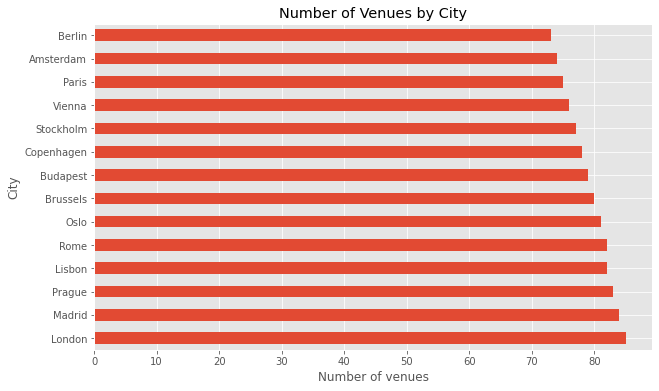

In [76]:
bar_overall.set_index("City").sort_values(by=["Total Venues"], ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Number of venues') 
plt.ylabel('City') 
plt.title('Number of Venues by City') 

plt.show()

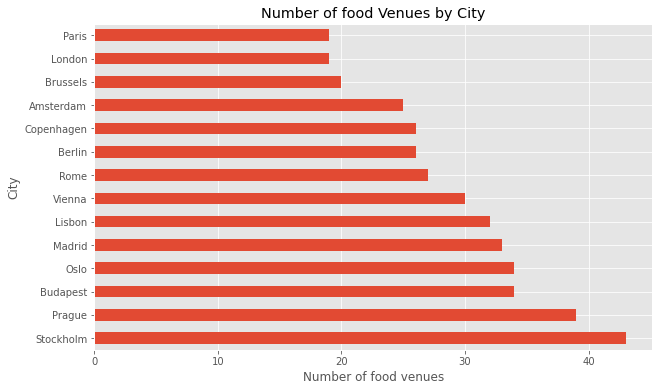

In [77]:
bar_food.set_index("City").sort_values(by=["Food"],ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Number of food venues') 
plt.ylabel('City') 
plt.title('Number of food Venues by City') 

plt.show()

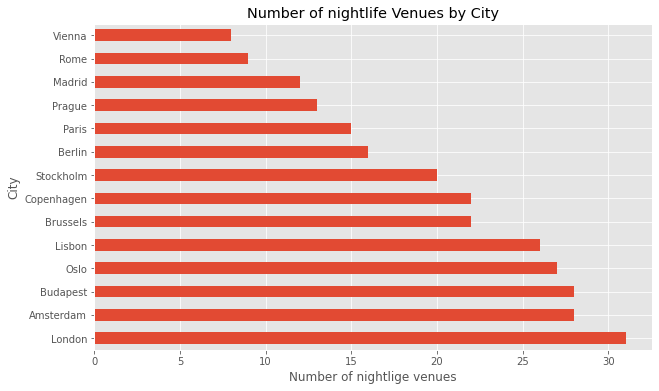

In [78]:
bar_nightlife.set_index("City").sort_values(by=["Nightlife"],ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Number of nightlige venues') 
plt.ylabel('City') 
plt.title('Number of nightlife Venues by City') 

plt.show()

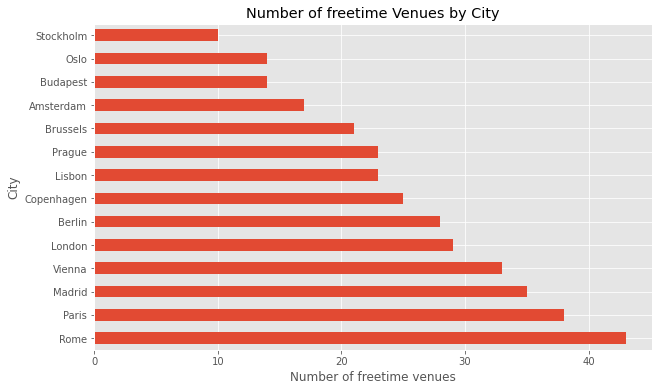

In [79]:
bar_freetime.set_index("City").sort_values(by=["Freetime"],ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Number of freetime venues') 
plt.ylabel('City') 
plt.title('Number of freetime Venues by City') 

plt.show()

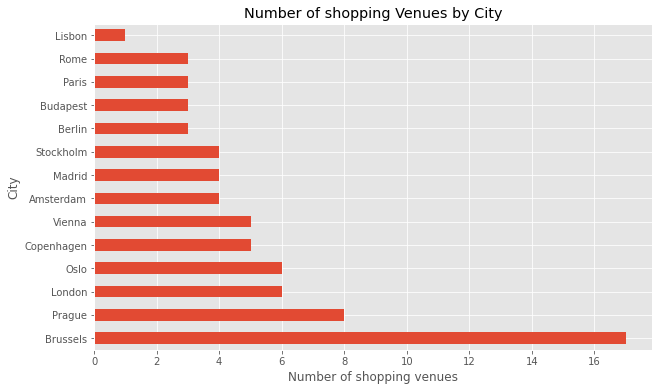

In [80]:
bar_shopping.set_index("City").sort_values(by=["Shopping"],ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Number of shopping venues') 
plt.ylabel('City') 
plt.title('Number of shopping Venues by City') 

plt.show()

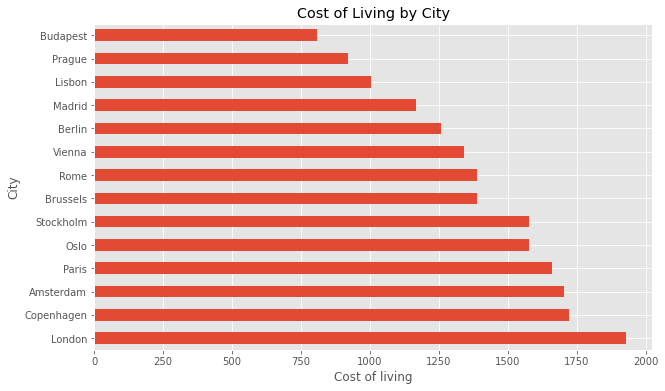

In [81]:
bar_cost.set_index("City").sort_values(by=["ESTIMATED COST OF LIVING(EUROS/MONTH)"],ascending=False).plot(kind='barh', figsize=(10, 6), legend=None)

plt.xlabel('Cost of living') 
plt.ylabel('City') 
plt.title('Cost of Living by City') 

plt.show()

Lets aggregate the data by Area and have a quick look at the summarized data.

In [82]:
eu_areas = pd.merge(eu_fine2,area,how="left",left_on="City",right_on="Name")
eu_areas.drop(["Name","Total Venues","City Latitude","City Longitude"],inplace=True,axis=1)
eu_areas["ESTIMATED COST OF LIVING(EUROS/MONTH)"]=eu_areas["ESTIMATED COST OF LIVING(EUROS/MONTH)"].astype(float)

area_group_food = eu_areas.groupby("Area")["Food"].mean().astype(int)
area_group_nightlife = eu_areas.groupby("Area")["Nightlife"].mean().astype(int)
area_group_freetime = eu_areas.groupby("Area")["Freetime"].mean().astype(int)
area_group_shopping = eu_areas.groupby("Area")["Shopping"].mean().astype(int)
area_group_pop = eu_areas.groupby("Area")["2021 Population"].mean().astype(int)
area_group_cost = eu_areas.groupby("Area")["ESTIMATED COST OF LIVING(EUROS/MONTH)"].mean().astype(int)

area_group = pd.concat([area_group_food,area_group_nightlife,area_group_freetime,area_group_shopping,
                       area_group_pop,area_group_cost],axis=1)
area_group["2021 Population"]=area_group["2021 Population"].astype(int)

area_group

,Food,Nightlife,Freetime,Shopping,2021 Population,ESTIMATED COST OF LIVING(EUROS/MONTH)
Area,,,,,,
Center_east,32,16,24,4,2006111,1081
Center_west,20,24,26,7,2864027,1668
North,34,23,16,5,1082877,1623
South,30,15,33,2,2030880,1186


Lets now visualize the data for each Category in form of a pie chart.

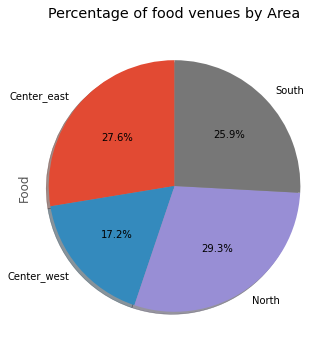

In [83]:
area_group["Food"].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,       
                            )

plt.title("Percentage of food venues by Area")
plt.axis('equal') 

plt.show()

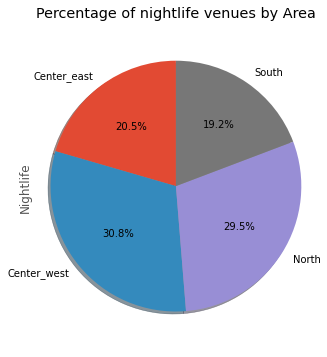

In [84]:
area_group["Nightlife"].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,       
                            )

plt.title("Percentage of nightlife venues by Area")
plt.axis('equal') 

plt.show()

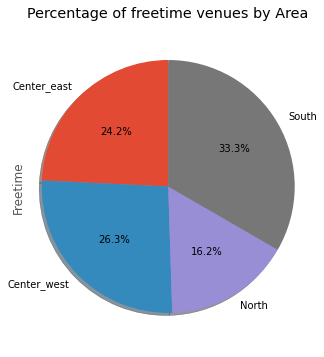

In [85]:
area_group["Freetime"].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,       
                            )

plt.title("Percentage of freetime venues by Area")
plt.axis('equal') 

plt.show()

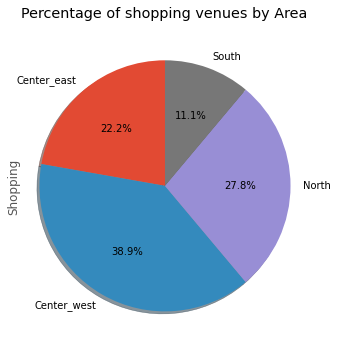

In [86]:
area_group["Shopping"].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,        
                            )

plt.title("Percentage of shopping venues by Area")
plt.axis('equal') 

plt.show()

Please check the report for additional information.